In [19]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

In [20]:
train = pd.read_csv("RentListingInquries_FE_train.csv")

In [21]:
train.head()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,...,manager_id_pred_2,display_address_pred_0,display_address_pred_1,display_address_pred_2,street_address_pred_0,street_address_pred_1,street_address_pred_2,features_count,photos_count,interest_level
0,1.5,3,40.7145,-73.9425,3000,1200.0,750.000000,-1.5,4.5,2016,...,0.334445,0.009369,0.026352,0.270365,0.009369,0.026352,0.083698,0,5,1
1,1.0,2,40.7947,-73.9667,5465,2732.5,1821.666667,-1.0,3.0,2016,...,0.276198,0.023753,0.112653,0.337808,0.009369,0.026352,0.521198,5,11,2
2,1.0,1,40.7388,-74.0018,2850,1425.0,1425.000000,0.0,2.0,2016,...,0.245804,0.022577,0.118805,0.281812,0.039804,0.148091,0.296742,4,8,0
3,1.0,1,40.7539,-73.9677,3275,1637.5,1637.500000,0.0,2.0,2016,...,0.255732,0.032702,0.073019,0.247032,0.051369,0.068352,0.237698,2,3,2
4,1.0,4,40.8241,-73.9493,3350,1675.0,670.000000,-3.0,5.0,2016,...,0.338244,0.009369,0.026352,0.258698,0.009369,0.026352,0.083698,1,3,2


In [22]:
# drop ids and get labels
y_train = train['interest_level']
train = train.drop(['interest_level'], axis=1)
X_train = np.array(train)

In [23]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [28]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =list(cv_folds.split(X_train, y_train)),
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print (cvresult)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds_1.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( 'n_estimators.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print (logloss)

     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              1.037745           0.000366             1.036740   
1              0.986683           0.000403             0.984776   
2              0.943545           0.000366             0.940658   
3              0.905982           0.000757             0.902193   
4              0.873266           0.000915             0.868603   
5              0.844624           0.000727             0.838987   
6              0.819884           0.000635             0.813190   
7              0.798180           0.000553             0.790613   
8              0.778818           0.000617             0.770390   
9              0.761752           0.001022             0.752265   
10             0.746293           0.001060             0.735992   
11             0.732854           0.001479             0.721698   
12             0.720546           0.001535             0.708780   
13             0.709676           0.001663             0.69707

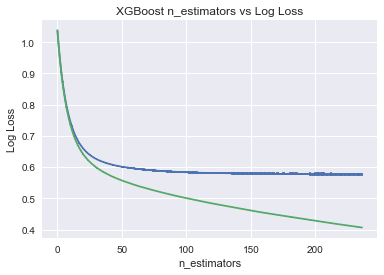

In [29]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 3}

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)


modelfit(xgb1, X_train, y_train, cv_folds = kfold)

In [26]:
list(kfold.split(X_train, y_train))

[(array([    0,     1,     2, ..., 49347, 49350, 49351]),
  array([    3,     4,    14, ..., 49328, 49348, 49349])),
 (array([    3,     4,     7, ..., 49349, 49350, 49351]),
  array([    0,     1,     2, ..., 49339, 49341, 49347])),
 (array([    0,     1,     2, ..., 49348, 49349, 49350]),
  array([    7,    17,    19, ..., 49343, 49344, 49351])),
 (array([    0,     1,     2, ..., 49348, 49349, 49351]),
  array([   11,    12,    13, ..., 49336, 49337, 49350])),
 (array([    0,     1,     2, ..., 49349, 49350, 49351]),
  array([    8,    10,    20, ..., 49340, 49345, 49346]))]

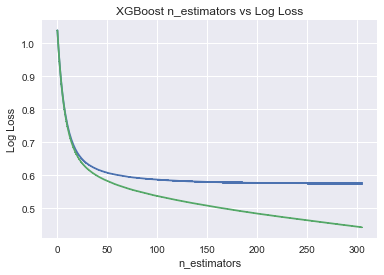

In [27]:
cvresult = pd.DataFrame.from_csv('my_preds_1.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()